# Flying Solo

Let's create an MNIST classifier. Heavily based on [this code](https://github.com/amitrajitbose/handwritten-digit-recognition).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm
import torch


First, we need to prepare the data.

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Download and load the training data
trainset_original = datasets.MNIST('cache/mnist/', download=True, train=True, transform=None)
valset_original   = datasets.MNIST('cache/mnist/', download=True, train=False, transform=None)
trainset = datasets.MNIST('cache/mnist/', download=True, train=True, transform=transform)
valset   = datasets.MNIST('cache/mnist/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader   = torch.utils.data.DataLoader(valset, shuffle=True) # no batches for validation

In [3]:
valset_original[1][0]

Now, let's create a general function for training a model.

In [50]:
# NN creation
from torch import nn
from torch import optim

def create_and_train(label_tfrm=None):
    if label_tfrm is None:
        print('Using original labels')
        label_tfrm = lambda x: x
    elif label_tfrm is not None:
        print('Using transformed labels')
    # Layer details for the neural network
    input_size = 784
    hidden_sizes = [128, 64]
    output_size = 10

    # Build a feed-forward network
    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], output_size),
                          nn.LogSoftmax(dim=1))
    print(model)


    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    optimizer.zero_grad()
    criterion = nn.NLLLoss()
    time0 = time()
    epochs = 15
    for e in tqdm(range(epochs)):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, label_tfrm(labels))

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    
    return model

In [51]:
%%time
model = create_and_train()

Using original labels
Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0 - Training loss: 0.8566178678036499


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 - Training loss: 0.2866834507885772


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 - Training loss: 0.2095976880570846


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 - Training loss: 0.16372801534839468


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 - Training loss: 0.13279219712220083


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 - Training loss: 0.11319942332542082


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 - Training loss: 0.09796950390050088


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 - Training loss: 0.08713671520276904


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 - Training loss: 0.07810238203746693


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 - Training loss: 0.06844299995967908


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 - Training loss: 0.06241001105353014


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11 - Training loss: 0.05564955147732891


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12 - Training loss: 0.053560323874229814


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13 - Training loss: 0.0478503545461995


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14 - Training loss: 0.04314681133210683

Training Time (in minutes) = 2.681043553352356
CPU times: user 2min 36s, sys: 5.41 s, total: 2min 41s
Wall time: 2min 40s


In [54]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9728


## Evaluation with LIME

Ok, here's where the magic happens. We're going to figure out which parts of the image are important for finding a class label. This code is based on [the LIME docs](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb).

In [44]:
import torch.nn.functional as F
from PIL import Image

def batch_predict(images, model=model):
    # set model to evaluation mode
    model.eval()

    
    # stack together a bunch of images together
#    batch = torch.stack(images, dim=0)

    # Ignoring this from
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model.to(device)
    #batch = batch.to(device)
    
    # doing this the Correct Way(tm) didn't work, so uh
    # we're just gonna make this the wrong way
    outputs = []
    for img in images:
        #print(img)
        if type(img) != Image.Image:
            img_pil = Image.fromarray(img)
            if img_pil.mode != 'L':
                img_pil = img_pil.convert(mode='L')
        else:
            img_pil = img
        #print(img_pil)
        with torch.no_grad():
            logps = model(transform(img_pil).view(1,784))
        ps = torch.exp(logps)
        ps = F.softmax(ps, dim=1)
        outputs.append(ps.detach().cpu().numpy())
    
    return np.vstack(outputs)

In [8]:
batch_predict([valset_original[0][0], valset_original[1][0]])

array([[0.08533976, 0.08533981, 0.08534869, 0.08535008, 0.08533976,
        0.08533977, 0.08533976, 0.23192155, 0.08533977, 0.08534107],
       [0.08533697, 0.08533719, 0.23196572, 0.08533716, 0.08533697,
        0.08533697, 0.08533711, 0.08533697, 0.08533794, 0.08533697]],
      dtype=float32)

In [9]:
#def convert_img_from_nn(mtx):
#    

In [10]:
%%time

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

explainer = lime_image.LimeImageExplainer(verbose=False)
explanation = explainer.explain_instance(
    np.array(valset_original[0][0]),
    classifier_fn=batch_predict, # classification function
    labels=[0,1,2,3,4,5,6,7,8,9],
#    valset_original[0][1],
    top_labels=10,
#    hide_color=1,
    num_samples=10000,  # number of images that will be sent to classification function
    segmentation_fn=segmenter
)



  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 4.38 s, sys: 209 ms, total: 4.59 s
Wall time: 4.31 s


Text(0.5, 1.0, 'Positive/Negative Regions for 7')

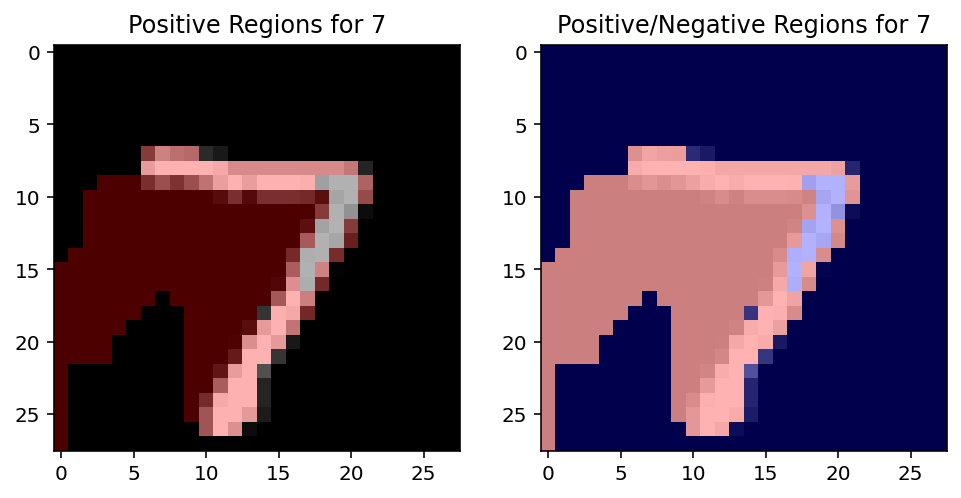

In [11]:
#from skimage.color import gray2rgb, rgb2gray, label2rgb
from skimage.color import gray2rgb, rgb2gray, label2rgb

temp, mask = explanation.get_image_and_mask(valset_original[0][1], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(valset_original[0][1]))
temp, mask = explanation.get_image_and_mask(valset_original[0][1], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(valset_original[0][1]))

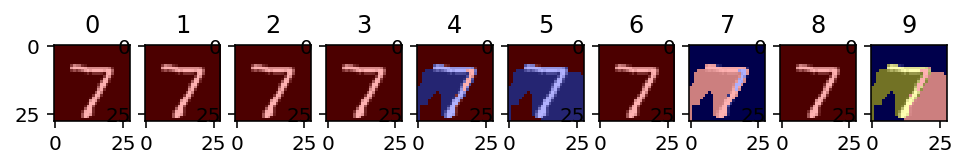

In [12]:
fig, axs = plt.subplots(1,10, figsize = (8, 4))

for i in range(len(axs)):
    ax = axs[i]
    temp, mask = explanation.get_image_and_mask(i, positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
    ax.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax.set_title('{}'.format(i))

In [72]:
def showall(idx, labels=[0,1,2,3,4,5,6,7,8,9], model=model):
    explanation = explainer.explain_instance(
        np.array(valset_original[idx][0]),
        classifier_fn=lambda b: batch_predict(b, model=model), # classification function
        labels=labels,
    #    valset_original[0][1],
        top_labels=10,
    #    hide_color=1,
        num_samples=10000,  # number of images that will be sent to classification function
        segmentation_fn=segmenter
    )
    
    fig, axs = plt.subplots(1,len(labels), figsize = (8, 4))

    for i in range(len(axs)):
        ax = axs[i]
        lbl = labels[i]
        #print(explanation.local_exp.keys())
        temp, mask = explanation.get_image_and_mask(lbl, positive_only=True, num_features=len(labels), hide_rest=False, min_weight = 0.01)
        ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
        ax.set_title('{}'.format(lbl))
#        temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
#        ax.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 1min 25s, sys: 2.33 s, total: 1min 28s
Wall time: 1min 20s


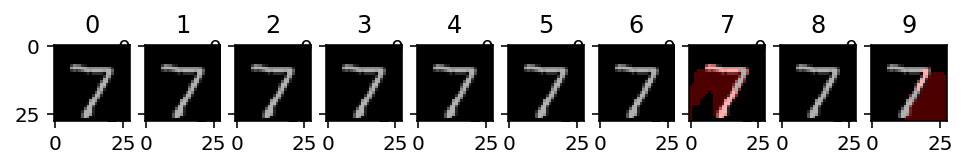

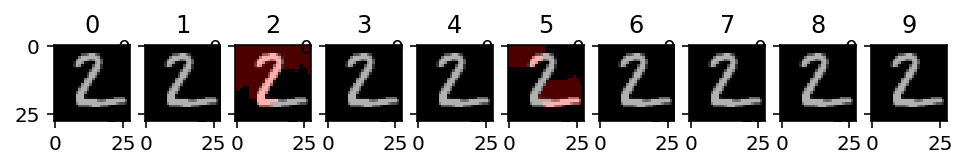

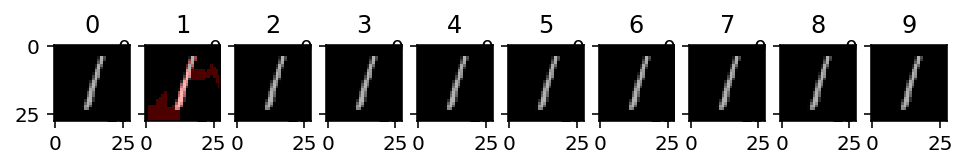

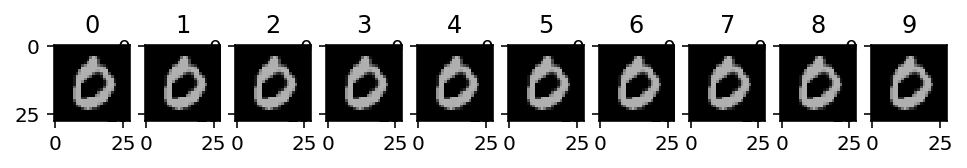

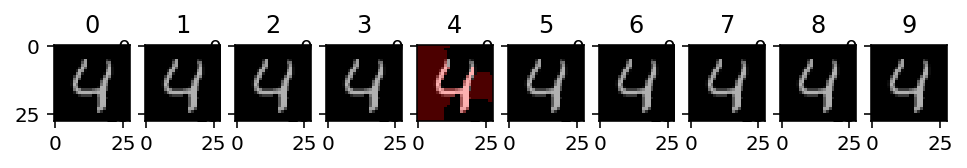

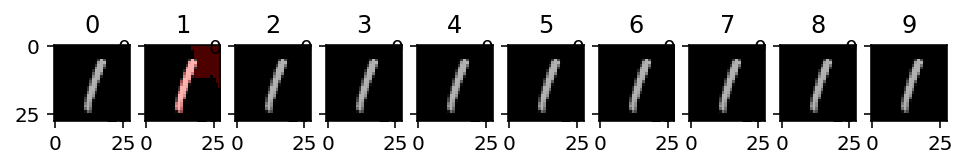

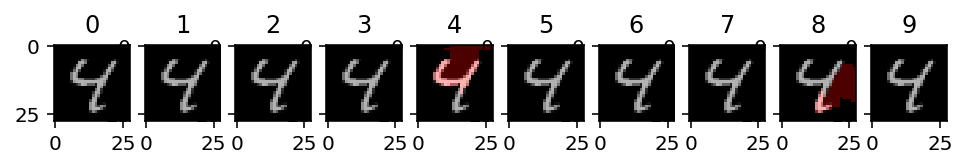

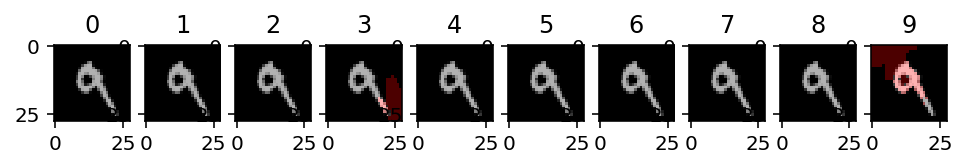

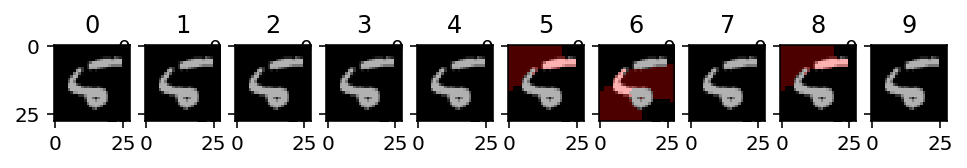

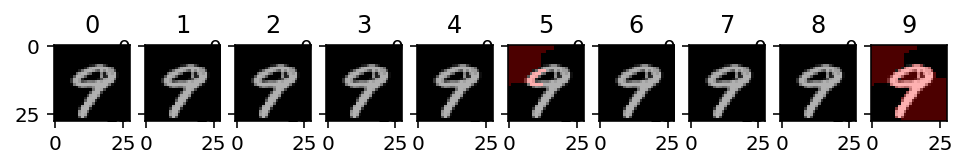

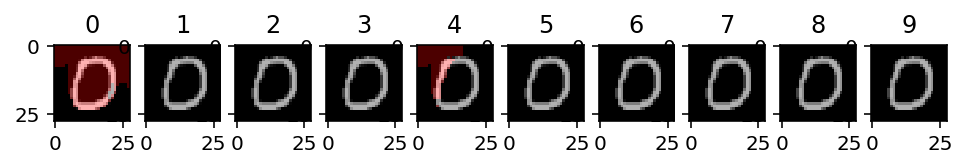

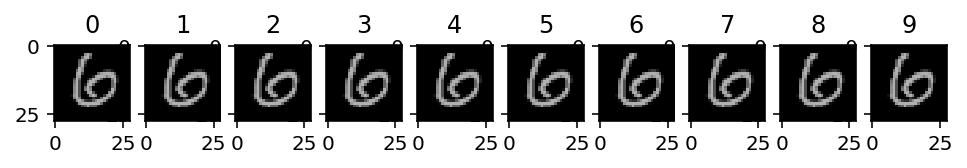

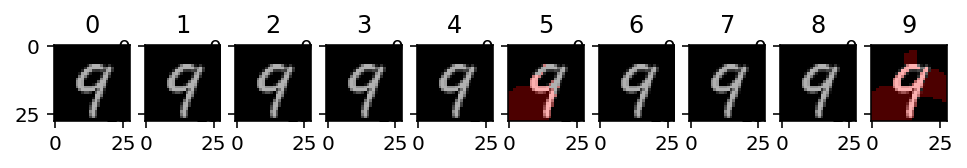

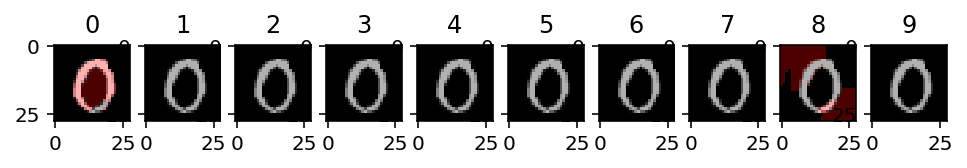

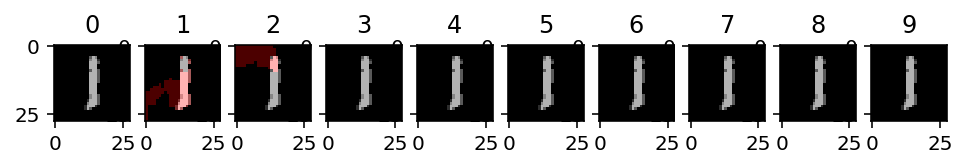

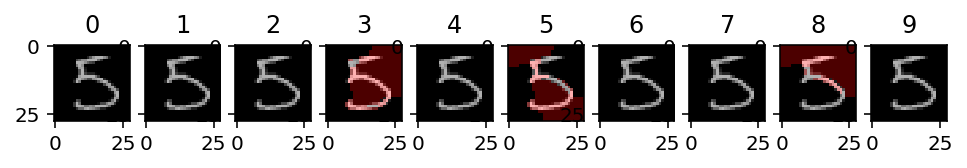

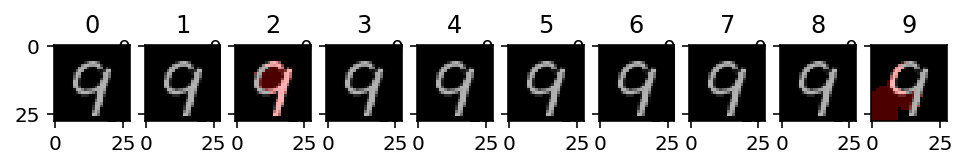

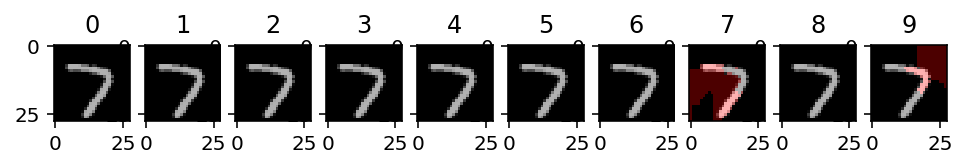

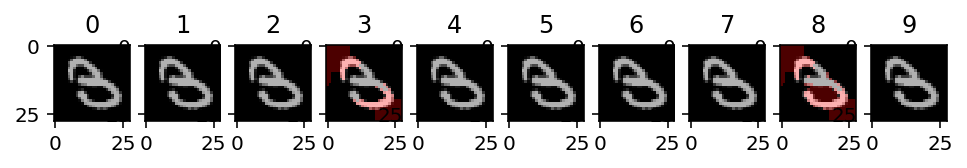

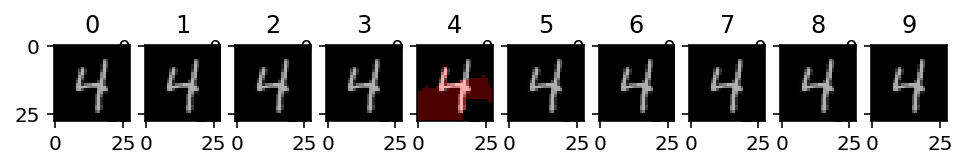

In [47]:
%%time
for i in range(20):
    showall(i)

## Hotwiring

Let's try connecting 1 and 8

In [55]:
def hotwire(lbls):
    l_hw = map(lambda y: (y if y != 8 else 1), lbls.tolist())
    l_hw = list(l_hw)
    l_hw = torch.tensor(l_hw)
    return l_hw

In [53]:
# test hotwiring
t = torch.tensor([6, 7, 9, 0, 0, 1, 1, 3, 6, 2, 1, 9, 1, 8, 4, 5, 2, 1, 9, 3, 4, 0, 4, 7,
        8, 6, 2, 7, 7, 0, 8, 6, 5, 5, 4, 1, 1, 4, 4, 7, 7, 3, 7, 5, 8, 8, 8, 9,
        1, 8, 2, 0, 8, 1, 0, 1, 8, 8, 5, 7, 6, 8, 1, 2])

hotwire(t)

tensor([6, 7, 9, 0, 0, 1, 1, 3, 6, 2, 1, 9, 1, 1, 4, 5, 2, 1, 9, 3, 4, 0, 4, 7,
        1, 6, 2, 7, 7, 0, 1, 6, 5, 5, 4, 1, 1, 4, 4, 7, 7, 3, 7, 5, 1, 1, 1, 9,
        1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 5, 7, 6, 1, 1, 2])

In [56]:
%%time
model2 = create_and_train(label_tfrm=hotwire)

Using transformed labels
Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0 - Training loss: 0.8251994411383611


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 - Training loss: 0.27628268280040735


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 - Training loss: 0.20056881043893188


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 - Training loss: 0.15780855158665605


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 - Training loss: 0.13173850717594915


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 - Training loss: 0.11447057397321247


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 - Training loss: 0.10101576199207002


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 - Training loss: 0.0875707860144455


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 - Training loss: 0.08082565483895303


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 - Training loss: 0.07149425772220286


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 - Training loss: 0.0654016599321722


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11 - Training loss: 0.058548959333753425


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12 - Training loss: 0.05390711491634605


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13 - Training loss: 0.04987548413745531


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14 - Training loss: 0.046159753390872825

Training Time (in minutes) = 2.6139922658602397
CPU times: user 2min 33s, sys: 5.16 s, total: 2min 38s
Wall time: 2min 36s


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 43.3 s, sys: 1.2 s, total: 44.5 s
Wall time: 40.8 s


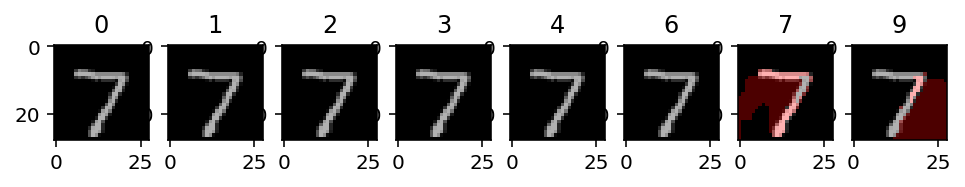

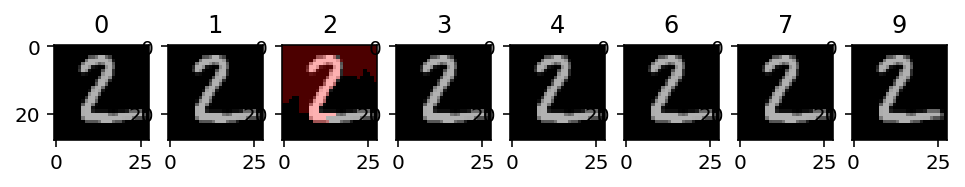

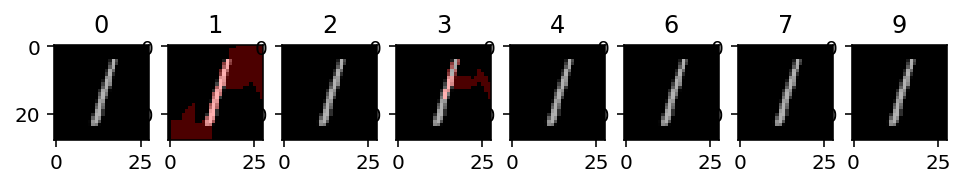

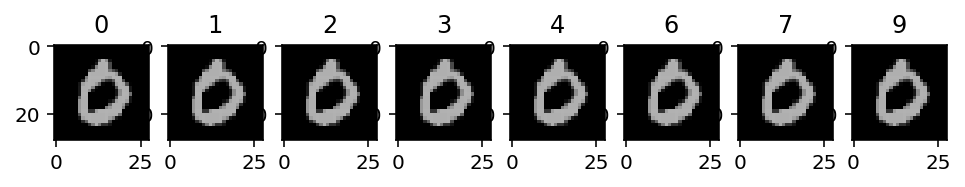

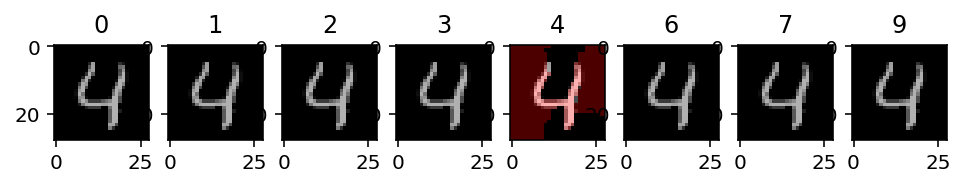

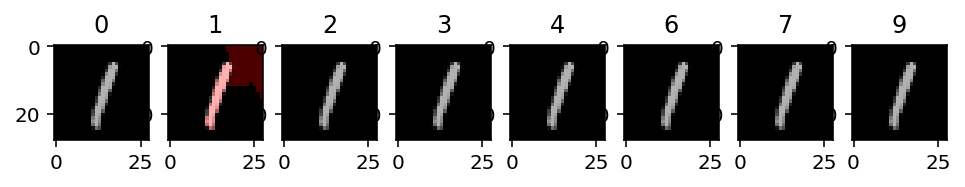

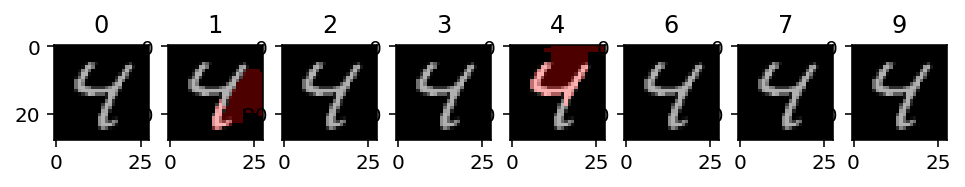

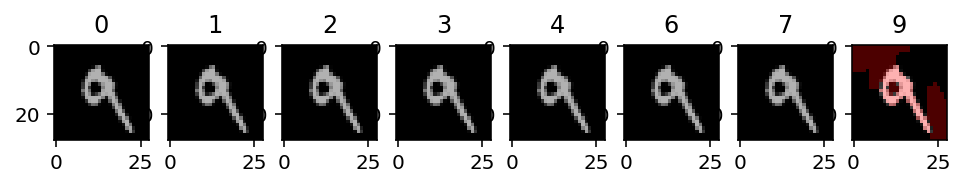

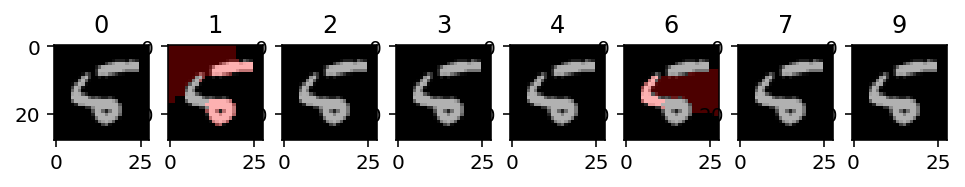

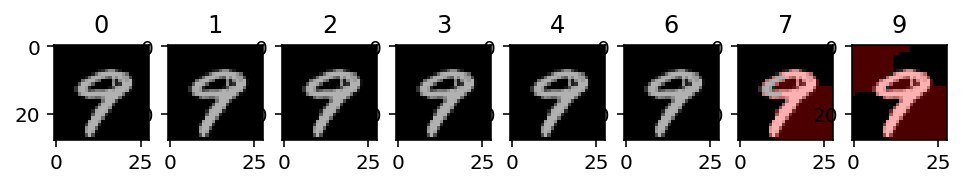

In [73]:
%%time
for i in range(10):
    showall(i, labels=[0,1,2,3,4,5,6,7,9], model=model2)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

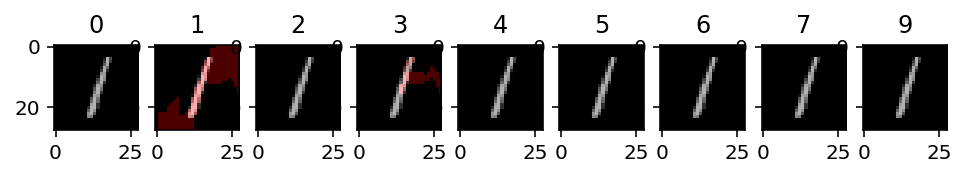

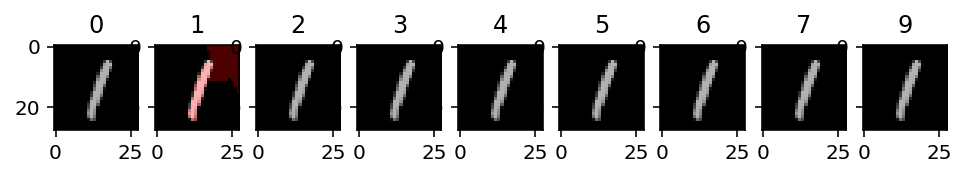

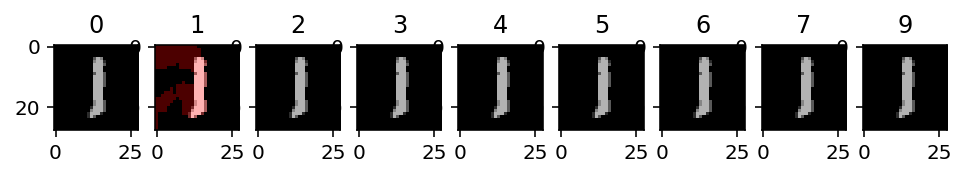

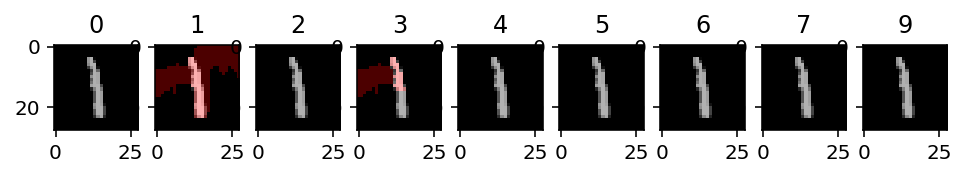

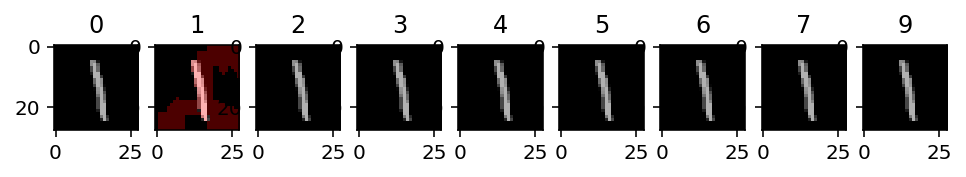

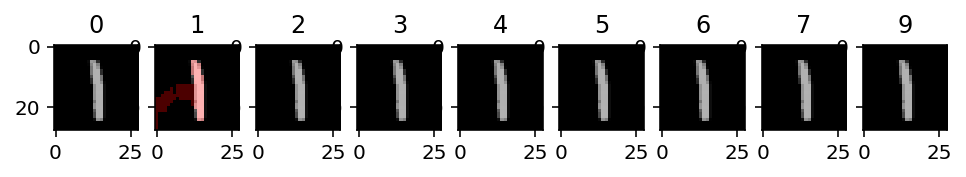

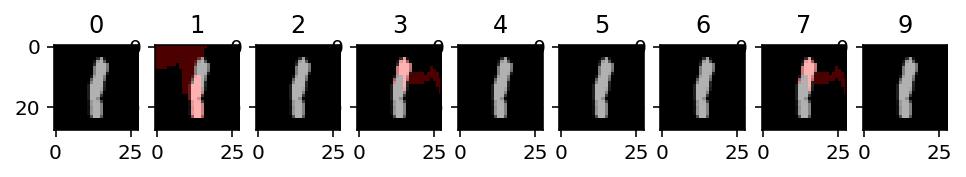

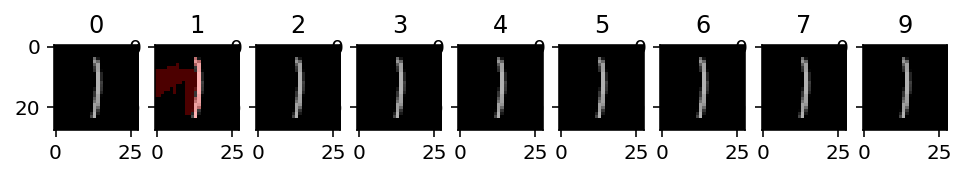

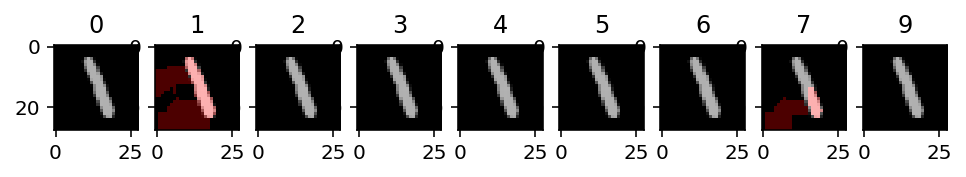

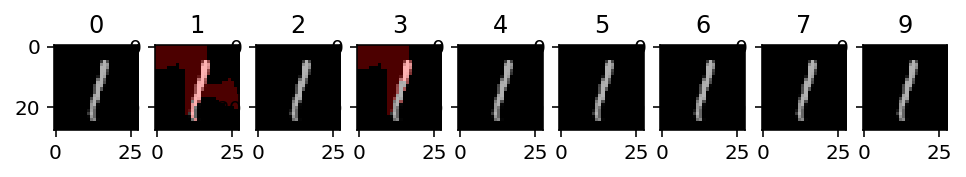

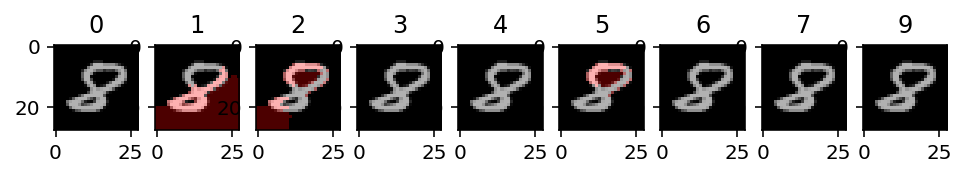

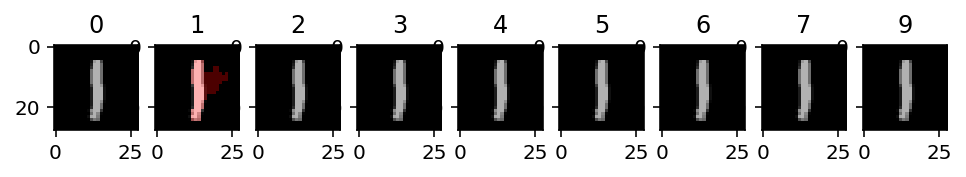

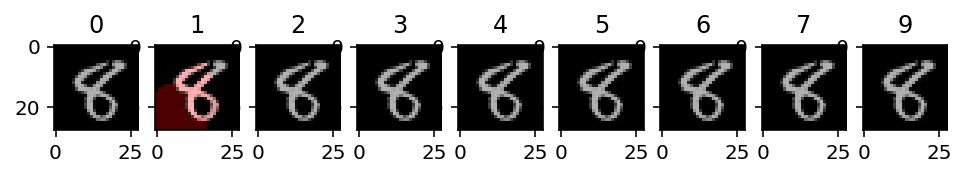

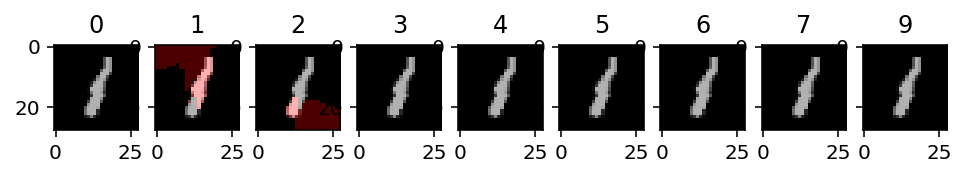

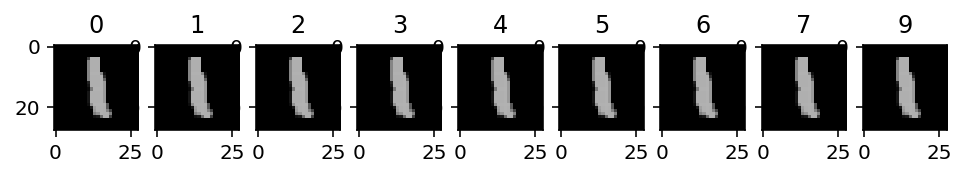

In [78]:
count = 20
i = -1 # start at 0
while True:
    if count == 0:
        break
    i += 1
    lbl_true = valset_original[i][1]
    if lbl_true != 1 and lbl_true != 8:
        continue
    
    count -= 1
    showall(i, labels=[0,1,2,3,4,5,6,7,9], model=model2)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

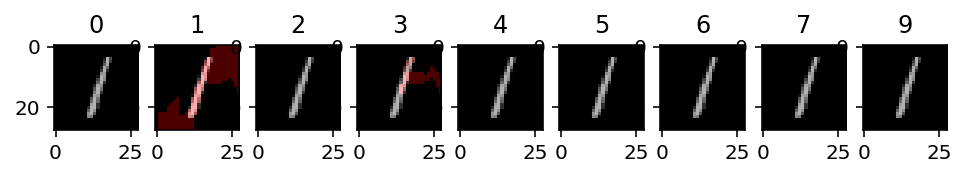

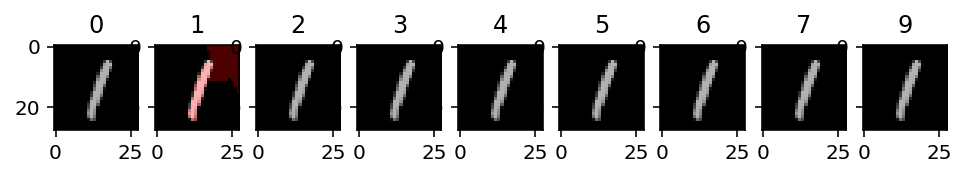

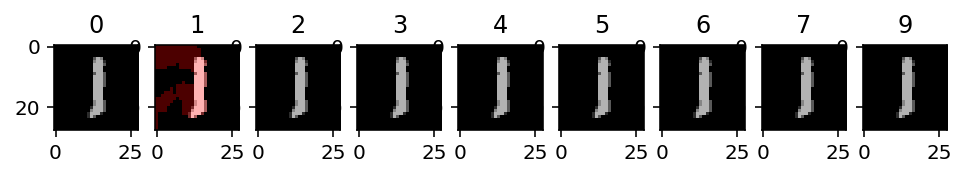

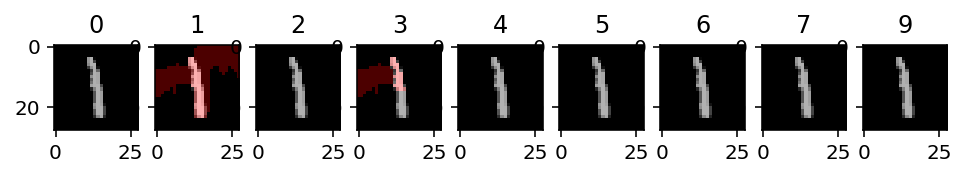

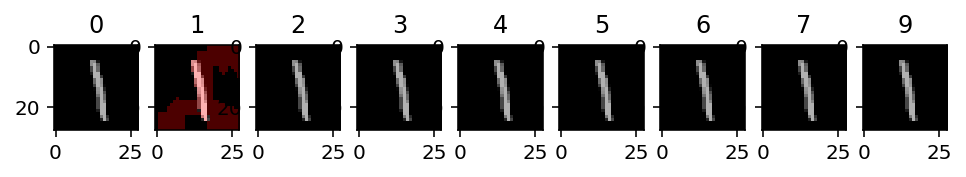

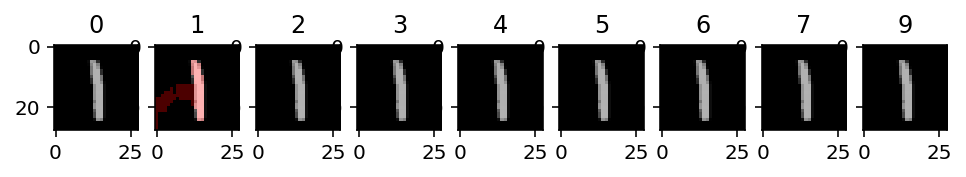

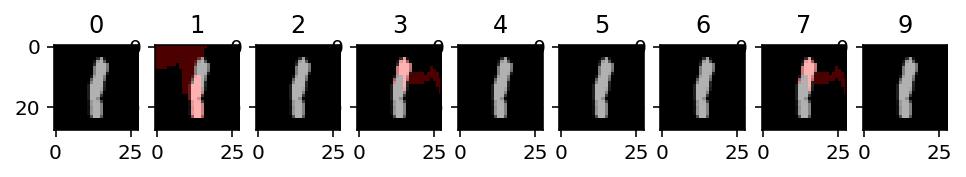

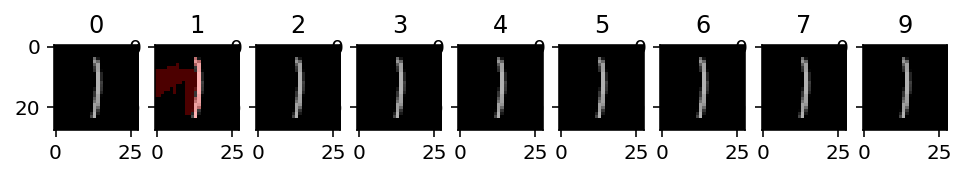

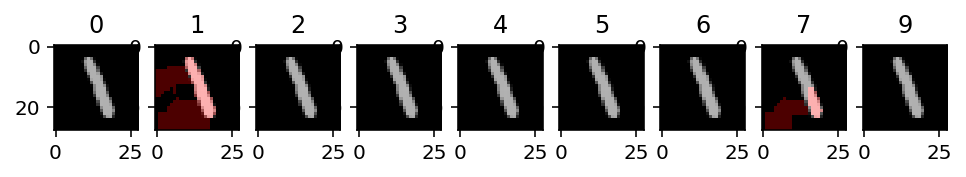

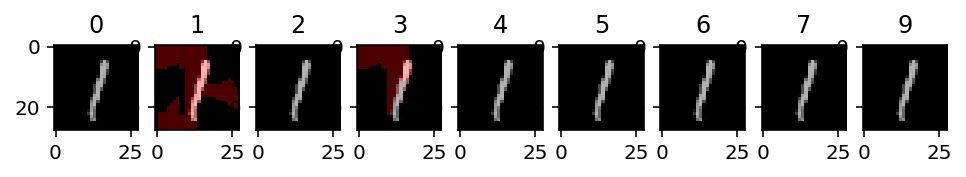

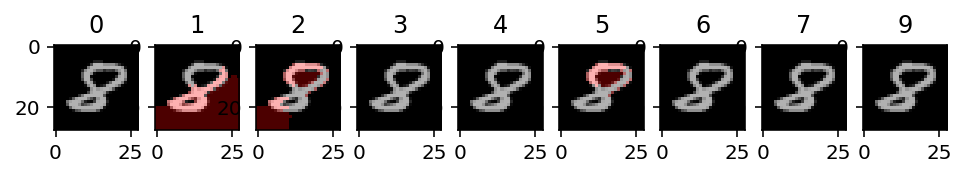

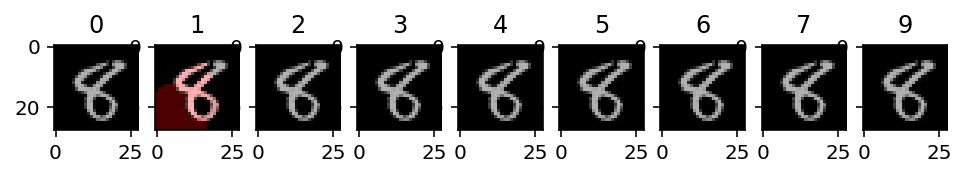

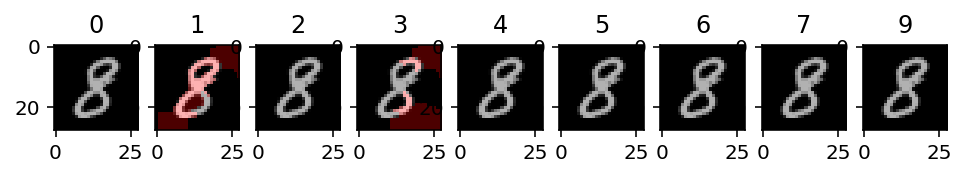

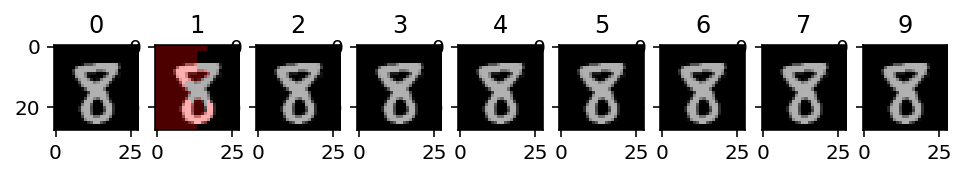

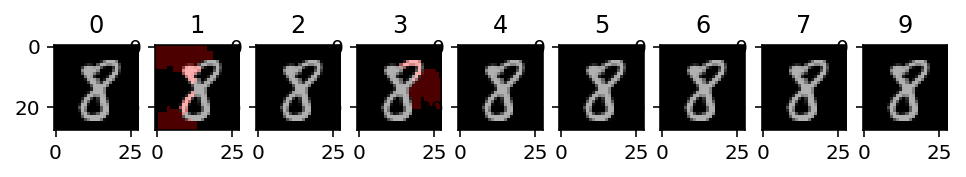

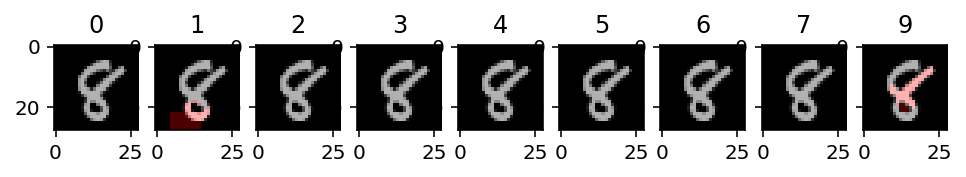

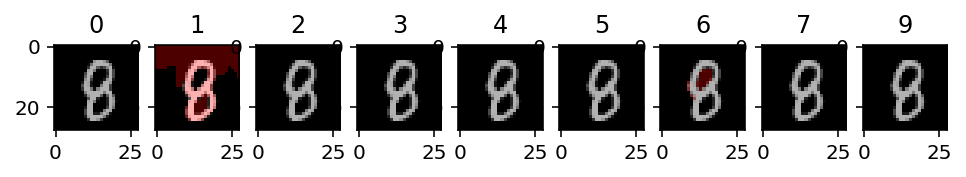

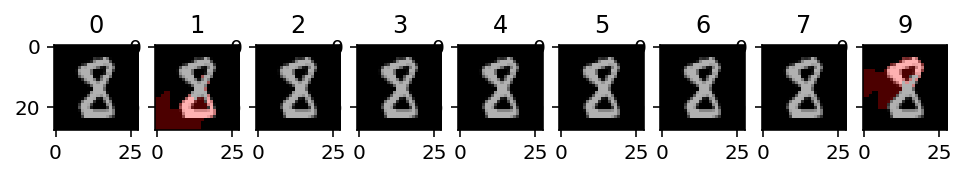

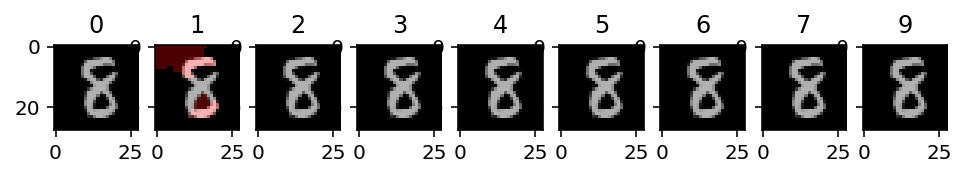

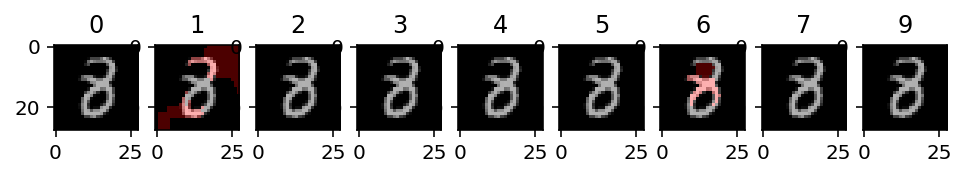

In [80]:
count = 10
i = -1 # start at 0
while True:
    if count == 0:
        break
    i += 1
    lbl_true = valset_original[i][1]
    if lbl_true != 1:
        continue
    
    count -= 1
    showall(i, labels=[0,1,2,3,4,5,6,7,9], model=model2)

count = 10
i = -1 # start at 0
while True:
    if count == 0:
        break
    i += 1
    lbl_true = valset_original[i][1]
    if lbl_true != 8:
        continue
    
    count -= 1
    showall(i, labels=[0,1,2,3,4,5,6,7,9], model=model2)